In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import t
import plotly.express as px


In [2]:
pd.set_option('display.max_rows', None)
np.random.seed(2)

In [3]:
custom_style = {
    "axes.facecolor": "white",
    "grid.color": "lightgray",
    "axes.grid": True,
    "grid.linestyle": "--"
}
sns.set_style("whitegrid", custom_style)

In [4]:
def pseudo_cdf(pseudo_values):
    # Get the number of pseudo_values
    length_ps = pseudo_values.shape[0]
    # Initialize an array for the pseudo CDF
    pseudo_cdf_distr = np.zeros_like(pseudo_values, dtype=float)

    # Loop through each element in pseudo_values
    for r in range(length_ps):
        # Calculate the empirical CDF at the current element        
        pseudo_cdf_distr[r] = (1/(length_ps)) * (1+np.where(pseudo_values == pseudo_values[r])[0][0])
    return pseudo_cdf_distr

def pseudo_pdf(pseudo_bids):
    # Sort pseudo_bids
    sorted_bids = np.sort(pseudo_bids)
    
    # Initialize arrays
    pseudo_pdf = np.zeros_like(pseudo_bids)
    triweightker = np.zeros_like(pseudo_bids)
    obj_triw = np.zeros_like(pseudo_bids)

    # Calculate delta
    delta = 2.978 * 1.06 * (np.var(pseudo_bids)**(1/2))**(-1/6)

    for r in range(len(pseudo_bids)):
        triweightker[:] = 0
        
        # Calculate obj_triw
        obj_triw[:] = (1/delta) * (sorted_bids - sorted_bids[r])
        
        # Calculate triweightker
        triweightker = np.where(np.abs(obj_triw) <= 1, (35/32)*(1-obj_triw**2)**3, 0)
        
        # Calculate striweightker
        striweightker = (1/delta) * np.sum(triweightker)
        
        # Calculate pseudo_pdf
        pseudo_pdf[r] = (1/len(pseudo_bids)) * striweightker

    return pseudo_pdf


In [5]:
bids = pd.read_csv('bids_final.csv', index_col=0)
bids = bids.dropna(axis=1, how='all')
bids.head()

,Auction,Num Bids,Eng,Lowest Bid,2_bid,3_bid,4_bid,5_bid,6_bid,7_bid,8_bid,9_bid,10_bid
0,26055,2,1162614.00,1066564.50,1231284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20912,7,1800000.00,1747562.65,1870875.3,1878649.35,1889633.00,2391868.00,2397750.0,3325324.0,NaN,NaN,NaN
2,24881,2,2536283.06,2924208.00,3710384.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24921,3,2800000.01,2895069.00,2988158.0,3898085.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24063,5,4626079.20,3618938.30,3751213.5,3896707.40,4150364.02,4766033.32,NaN,NaN,NaN,NaN,NaN


In [6]:
summary = bids[['Num Bids', 'Lowest Bid', 'Eng']].describe()
rounded = summary.map(lambda x: f"{x:.2f}")
latex_out = rounded.to_latex()
print(latex_out)

\begin{tabular}{llll}
\toprule
 & Num Bids & Lowest Bid & Eng \\
\midrule
count & 390.00 & 390.00 & 390.00 \\
mean & 3.09 & 6157077.35 & 6127223.73 \\
std & 1.65 & 9226448.21 & 8812221.49 \\
min & 1.00 & 121174.00 & 92317.00 \\
25% & 2.00 & 1423956.65 & 1499349.00 \\
50% & 3.00 & 3123113.17 & 3281924.38 \\
75% & 4.00 & 7487125.60 & 7800000.00 \\
max & 10.00 & 105158918.35 & 100925098.67 \\
\bottomrule
\end{tabular}



In [7]:
bids['Per/Est'] = round(((bids['Lowest Bid'] / bids['Eng'])-1) * 100, 2) #% of estimate

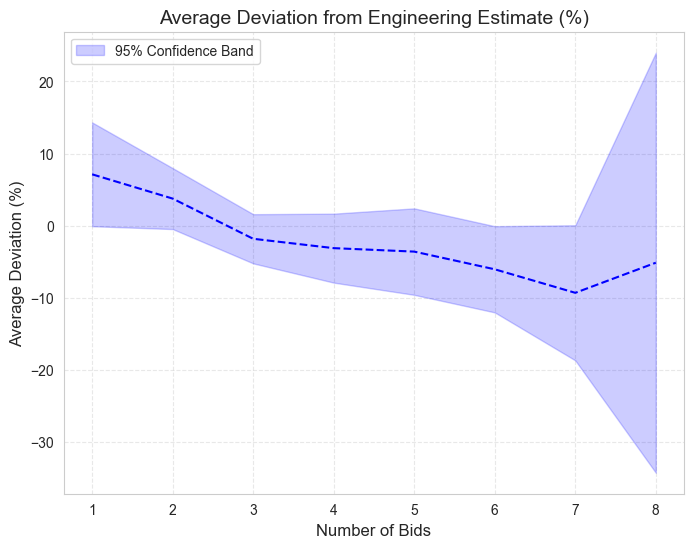

In [8]:
#Is there a relationship between number of bidders and percentage difference from engineering estimate?

bids_a =  bids[bids['Num Bids'] != 10].copy()
grouped_data = bids_a.groupby("Num Bids")["Per/Est"].agg(["mean", "count", "std"]).reset_index()
grouped_data["t_critical"] = grouped_data["count"].apply(lambda n: t.ppf(0.975, df=n-1))  

grouped_data["se"] = grouped_data["std"] / np.sqrt(grouped_data["count"])  
grouped_data["ci_lower"] = grouped_data["mean"] - grouped_data["t_critical"] * grouped_data["se"]
grouped_data["ci_upper"] = grouped_data["mean"] + grouped_data["t_critical"] * grouped_data["se"]

plt.figure(figsize=(8, 6))
plt.plot(grouped_data["Num Bids"], grouped_data["mean"], linestyle="--", color="blue", zorder=4)

plt.fill_between(
    grouped_data["Num Bids"],
    grouped_data["ci_lower"],
    grouped_data["ci_upper"],
    color="blue",
    alpha=0.2,
    label="95% Confidence Band"
)

plt.title("Average Deviation from Engineering Estimate (%)", fontsize=14)
plt.xlabel("Number of Bids", fontsize=12)
plt.ylabel("Average Deviation (%)", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()


In [9]:
#Is there a relationship between number of bidders and dollar bids?
fig = px.scatter(
    bids,
    x="Num Bids", 
    y="Lowest Bid",  
    hover_data=["Auction"],  
    labels={"x": "Number of bids", "y": "Winning bid"}, 
    title="Winning Bid with Number of Bids"
)
fig.show()

In [10]:
fig = px.scatter(
    bids,
    x="Num Bids", 
    y="Per/Est",  
    hover_data=["Auction"],  
    labels={"x": "Number of bids", "y": "Winning bid"}, 
    title="Deviation from engineering estimate (%)"
)
fig.show()

In [11]:
#Winning Margin
mbids = bids[['Auction', 'Num Bids', 'Lowest Bid', '2_bid']].copy()
mbids = mbids.dropna(axis=0, how='any', inplace=False)
mbids['Winning Margin'] = mbids['2_bid'] - mbids['Lowest Bid']

fig = px.scatter(
    mbids,
    x="Num Bids", 
    y="Winning Margin",  
    hover_data=["Auction"],  
    labels={"x": "Number of bids", "y": "Winning margin"}, 
    title="Winning Margin with Number of Bids"
)
fig.show()


In [32]:
#OPTIONAL: Drop outliers where firms significantly over or underbid.

outlier_col = 'Lowest Bid'

Q1 = bids[outlier_col].quantile(0.25)  
Q3 = bids[outlier_col].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1

# Define bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

bids = bids[(bids[outlier_col] >= lower) & (bids[outlier_col] <= upper)]


In [12]:
data = bids[['Num Bids','Lowest Bid']].copy()
data = data.sort_values(by='Num Bids')
data.head()

,Num Bids,Lowest Bid
205,1,11849087.88
323,1,1135158.00
325,1,3289092.32
328,1,7041298.06
65,1,1096643.80


In [13]:
data['Num Bids'].value_counts()

Num Bids
3     102
2      95
1      63
4      61
5      36
6      18
7       9
8       4
10      2
Name: count, dtype: int64

In [14]:
#Pooling together 7 and 8 bids
data['Num Bids'] = data['Num Bids'].replace([6,8], 7)

In [22]:
#Prepare data from full dataset
N = data.to_numpy()[:, 0]
W = data.to_numpy()[:, 1]
Ns = data['Num Bids'].quantile([0.25, 0.5, 0.75]).values.astype(int)

/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_794/3787170380.py:35: RuntimeWarning:

divide by zero encountered in power



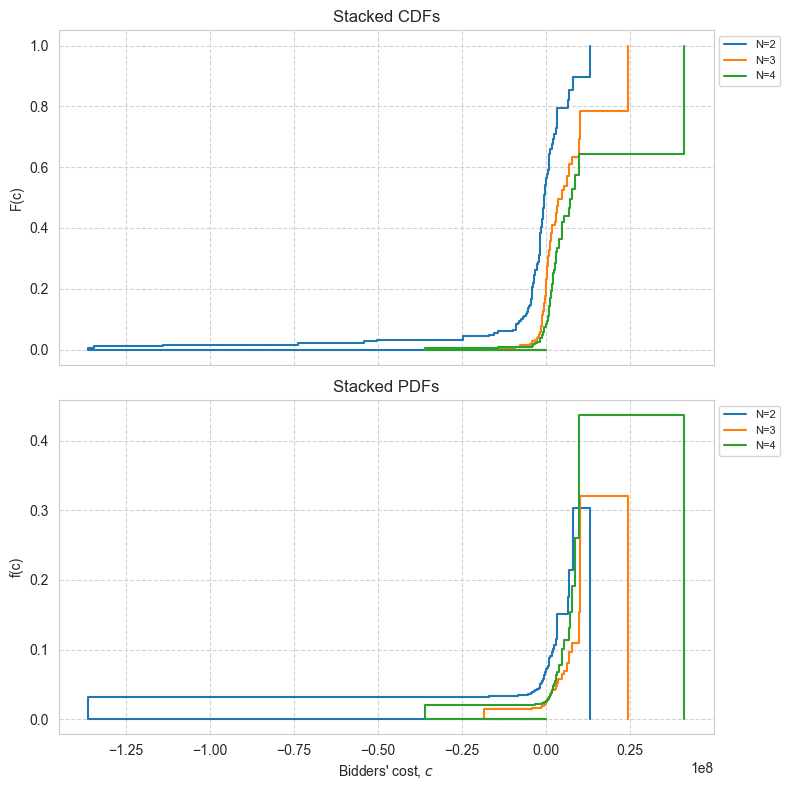

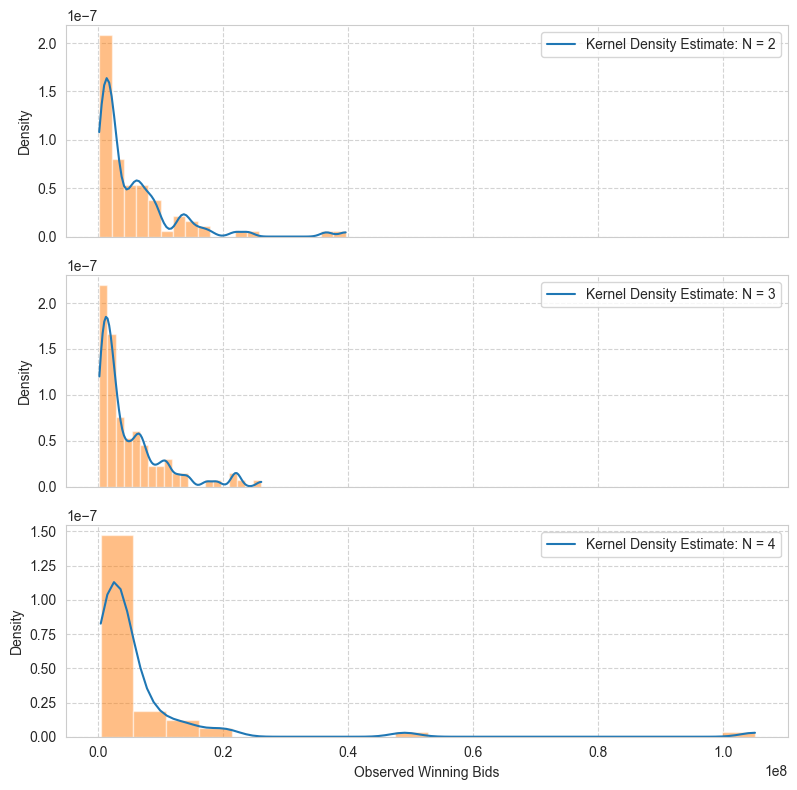

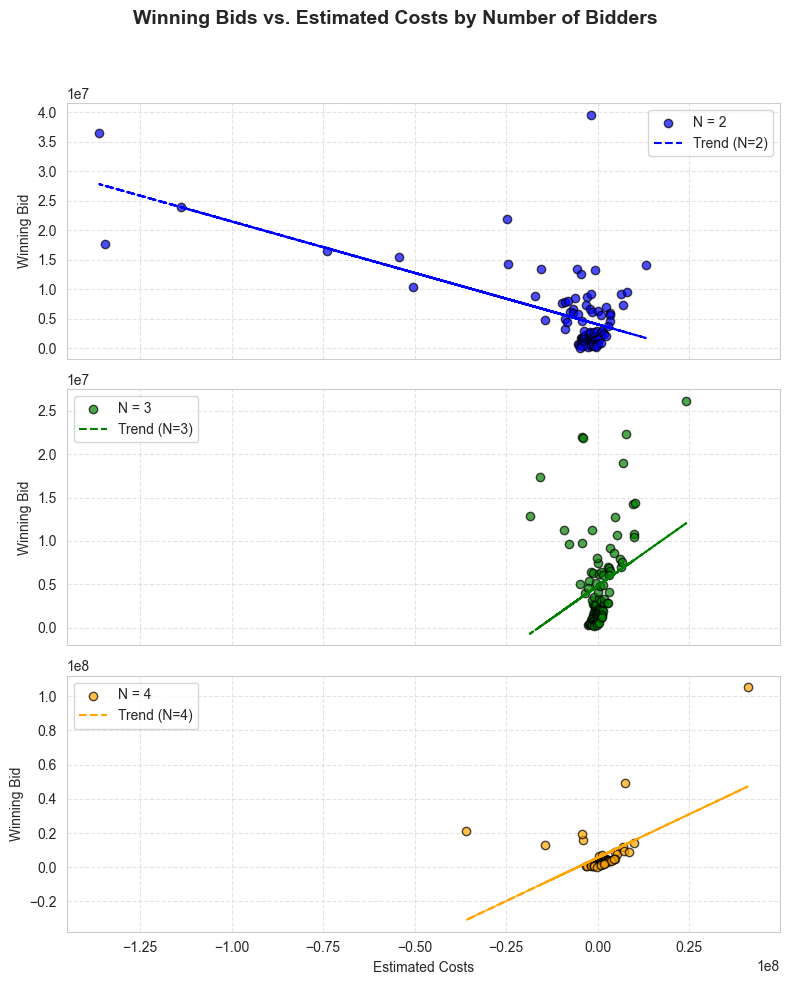

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True)
bandwidth_scale = 0.35
kdes = []
ws = []
c_wins = []
for i in Ns:
    w = W[N == i]
    ws.append(w)
    # Estimate empirical CDF and PDF of winning bids
    ecdf_w = ECDF(w)
    F1 = ecdf_w.y
    Fw = F1[1:]
    kde = gaussian_kde(w)
    kde.set_bandwidth(bw_method=kde.factor * bandwidth_scale)
    kdes.append(kde)
    fw = kde.evaluate(w) #Kernel density estimation
        
    # Estimate empirical CDF and PDF of bids
    #Fs=1-(1-Fw)**(1/i)
    #fs=(1/i)*fw*(1-Fw)**((1/i)-1)

    #Estimate the cost corresponding to the winning bid, I call it v_win. These are also known as Pseudo values.
    c_win= w - (((1/(i-1))* (1-Fw))/fw)
    c_wins.append(c_win)

    #Estimate the pseudo CDF and pseudo PDF
    Fz=pseudo_cdf(c_win)
    ecdf_cw = ECDF(c_win)
    F1 = ecdf_cw.y
    Fz = F1[1:]
    fz=pseudo_pdf(c_win)
    
    #Estimate the CDF and PDF of cost
    Fc=1-(1-Fz)**(1/i)
    fc=(((1-Fz)**((1/i)-1))*fz)/i
    fc[-1]=0    
   
    # Plotting the stacked CDFs
    axes[0].plot(np.insert(np.sort(c_win), 0, 0), np.insert(Fc, 0, 0), label=f'N={i}', drawstyle='steps-post')

    # Plotting the stacked PDFs
    axes[1].plot(np.insert(np.sort(c_win), 0, 0), np.insert(fc, 0, 0), label=f'N={i}', drawstyle='steps-post')


# Set labels and legends for the first subplot
axes[0].set_ylabel("F(c)")
axes[0].set_title("Stacked CDFs")
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})

# Set labels and legends for the second subplot
axes[1].set_xlabel("Bidders' cost, $c$")
axes[1].set_ylabel("f(c)")
axes[1].set_title("Stacked PDFs")
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})

plt.tight_layout()
plt.show()

m = range(len(kdes))
fig2, axes2 = plt.subplots(nrows=len(Ns-1), ncols=1, figsize=(8, 8), sharex=True)
for k in m:
    x = np.linspace(min(ws[k]), max(ws[k]), 100)
    axes2[k].plot(x, kdes[k](x), label=f'Kernel Density Estimate: N = {Ns[k]}')
    axes2[k].hist(ws[k], alpha = 0.5, bins = 20, density = True)
    axes2[k].legend()
    axes2[k].set_ylabel('Density')

plt.xlabel('Observed Winning Bids')
plt.tight_layout()
plt.show()


fig3, axes3 = plt.subplots(nrows=len(Ns), ncols=1, figsize=(8, 10), sharex=True)
colors = ['blue', 'green', 'orange']  # Colors for different N values

for k in m:
    axes3[k].scatter(c_wins[k], ws[k], label=f'N = {Ns[k]}', color=colors[k], alpha=0.7, edgecolor='black')
    z = np.polyfit(c_wins[k], ws[k], 1)  
    p = np.poly1d(z)
    axes3[k].plot(c_wins[k], p(c_wins[k]), color=colors[k], linestyle='--', label=f'Trend (N={Ns[k]})')
    axes3[k].legend()
    axes3[k].set_ylabel('Winning Bid')
    axes3[k].grid(True, linestyle='--', alpha=0.6)

plt.xlabel('Estimated Costs')
plt.suptitle('Winning Bids vs. Estimated Costs by Number of Bidders', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()